# Chatbot con Red Neuronal Sequential (Keras)

Librerías necesarias:

In [2]:
## Librerías:
# ... Para 'intents.json'
import json # Para el formato json
import codecs # Lectura de caracteres en español (tildes y 'ñ')
# ... Procesamiento de Lenguaje Natural
import spacy # Lemmatizer (convertir palabras) con lenguaje español
import pickle # Guardar archivos
import numpy as np 
import nltk # Natural Language ToolKit: Tokenizar
from recursos import lemmatizer, normalize_tilde

Para crear la Red Neuronal Secuencial con Keras:

In [3]:
# Redes Neuronales:
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import SGD

## Entrenamiento
El siguiente código es el mismo que se puede encontrar en *training.py*

In [4]:
## 1. Cargar la información del archivo json

def load_training_data(json_file = "intents.json"):
    # Cargar archivo json:
    intents = json.loads(codecs.open(json_file, encoding='utf-8').read())
    
    words = [] # Palabras individuales usadas
    tags = [] # Etiquetas de intención
    ignore_letters = ['¿', '?', '.', ',', ';', '¡', '!', '(', ')']
    documents = [] # Lista de tuplas ([Lista de palabras], etiqueta asociada de intención)
    for intent in intents['intents']:
        # Por cada intención:
        for pattern in intent['patterns']:
            # Tokenizar el patrón de palabras que usaría el usuario y agregar las palabras a 'words'.
            pattern = lemmatizer(pattern) #........ Para separar '¿__w1__w2' y pasar palabras a su forma base.
            pattern = normalize_tilde(pattern) #... Quitas las tildes.
            word_list = nltk.word_tokenize(pattern)
            words.extend(word_list)
            # Agregar a 'documents' la tupla (lista de palabras, etiqueta de la intención)
            documents.append((word_list, intent['tag']))
            if intent['tag'] not in tags:
                tags.append(intent['tag'])
            # Fin del segundo bucle
        # Fin del primer bucle
    words = [lemmatizer(word.lower()) for word in words if word not in ignore_letters]
    words = sorted(set(words))
    tags = sorted(set(tags))
    """
    Ejemplo:
    - words = ['Buen', 'Hola', 'día', ...]
    - tags = ['saludos', 'opciones', 'consulta_lugar']
    - documents = [(['Buen', 'día'], 'saludos'), (['Hola'], 'saludos'), ([...], 'opciones'), ...]
    """
    return words, tags, documents

words, tags, documents = load_training_data() # 'documents' ayudará a crear la matriz de entrenamiento
print("intents.json cargado")
print("Palabras detectadas:", len(words))
print("Intenciones detectadas:", len(tags))

intents.json cargado
Palabras detectadas: 138
Intenciones detectadas: 13


In [5]:
# ... Guardar las palabras y tags
pickle.dump(words, open('words.pkl', 'wb'))
pickle.dump(tags, open('tags.pkl', 'wb'))

# 2. Bag of Words: Formar matriz Training 

training = []
output_empty = [0] * len(tags)

for document in documents:
    # Por cada tupla ([consulta de palabras], tag)
    bag = [] # ... bag of words
    word_patterns = document[0] #... lista de palabras
    word_patterns = [lemmatizer(word.lower()) for word in word_patterns] #... lematizar las palabras en minúsculas
    for word in words:
        # Por cada palabra en el conjunto total de palabras encontradas en el archivo json.
        bag.append(1) if word.lower() in word_patterns else bag.append(0)
        # Si dicha palabra está entre el patrón de este documento: 1; else -> 0
    # - bag = [0,0,0,...,1], de len(bag) = len(words)
    
    output_row = list(output_empty) # Hacer una lista de 0, del tamaño de len(tags)
    output_row[tags.index(document[1])] = 1 # Cambia a '1' la celda de mismo índice que tag en tags.
    training.append([bag, output_row]) # Se agrega a la matriz de Training.

random.shuffle(training) # Mezclar Data de Entrenamiento
training = np.array(training)
print("Formada matriz training. Filas: %s, Etiquetas:%s)"%(len(training), len(training[0][1])))

train_x = list(training[:,0]) # Entradas
train_y = list(training[:,1]) # Salidas

model = Sequential()
model.add(Dense(128, input_shape=(len(train_x[0]),), activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_y[0]), activation = 'softmax'))

sgd = SGD(lr = 0.01, decay =1e-6, momentum=0.9, nesterov = True)

model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.fit(np.array(train_x), np.array(train_y), epochs=200, batch_size=5, verbose = 1)
model.save('chatbot_model.model')
print("Red Neuronal Guardada")

Formada matriz training. Filas: 169, Etiquetas:13)
Train on 169 samples
Epoch 1/200
169/169 [==============================] - 4s 22ms/sample - loss: 2.5455 - accuracy: 0.1124
Epoch 2/200
169/169 [==============================] - 0s 846us/sample - loss: 2.4072 - accuracy: 0.2485
Epoch 3/200
169/169 [==============================] - 0s 1ms/sample - loss: 2.2408 - accuracy: 0.2367
Epoch 4/200
169/169 [==============================] - 0s 1ms/sample - loss: 2.0138 - accuracy: 0.3373
Epoch 5/200
169/169 [==============================] - 0s 1ms/sample - loss: 1.8490 - accuracy: 0.3728
Epoch 6/200
169/169 [==============================] - 0s 1ms/sample - loss: 1.6009 - accuracy: 0.5562
Epoch 7/200
169/169 [==============================] - 0s 1ms/sample - loss: 1.5688 - accuracy: 0.48520s - loss: 1.5964 - accuracy: 0.
Epoch 8/200
169/169 [==============================] - 0s 1ms/sample - loss: 1.3058 - accuracy: 0.5621
Epoch 9/200
169/169 [==============================] - 0s 1ms/sample 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: chatbot_model.model\assets


INFO:tensorflow:Assets written to: chatbot_model.model\assets


Red Neuronal Guardada


## Estudiar el Chatbot

Cargar el modelo de Red Neuronal:

In [4]:
from tensorflow.keras.models import load_model

model = load_model('chatbot_model.model')
words = pickle.load(open('words.pkl','rb'))
tags = pickle.load(open('tags.pkl','rb'))
print(tags)

['consulta_categoria', 'consulta_funciones', 'consulta_lugar', 'consulta_lugares_cerca', 'consulta_precio', 'consulta_recomendacion', 'consulta_tiempo', 'consulta_trivia', 'contexto', 'despedida', 'gracias', 'nulo', 'saludos']


Funciones para la representación de Bag of Words.

Estas funciones son las mismas que se usan en chatbot.py

In [5]:
def clean_up_sentence(sentence):
    """
    Limpiar oración de entrada (lematizar cada palabra)
    """
    sentence_words = nltk.word_tokenize(sentence)
    sentence_words = [lemmatizer(word) for word in sentence_words]
    return sentence_words

def bag_of_words(sentence):
    """
    Convertir la oración de entrada a bag_of_words
    """
    sentence_words = clean_up_sentence(sentence)
    # sentence_words: Arreglo de las palabras lematizadas
    bag = [0] * len(words)
    # bag: Arreglo de 0s
    for w in sentence_words:
        for i, word in enumerate(words):
            if word == w:
                bag[i] = 1
                # Cambiar a '1' donde haya incidencia (bag of words)
    return np.array(bag)

### Conjunto de datos de prueba

In [7]:
test_intents = json.loads(codecs.open('test_intents.json', encoding='utf-8').read())

X_test = []
Y_test_array = []
Y_test_tagged = []

for intent in test_intents['intents']:
    for pattern in intent['patterns']:
        pattern = lemmatizer(pattern.lower())
        bow = bag_of_words(pattern)
        X_test.append(bow)
        Y_test_tagged.append(intent['tag'])
        
        output_row = list([0 for i in range(len(tags))]) # Hacer una lista de 0, del tamaño de len(tags)
        output_row[tags.index(intent['tag'])] = 1 # Cambia a '1' la celda de mismo índice que tag en tags.
        Y_test_array.append(output_row)

print("X:")  
print(X_test[:2])
print("Y:")
print(Y_test_array[:5])
print("Y:")
print(Y_test_tagged[:5])

X:
[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])]
Y:
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0,

In [9]:
def make_predict(bow):
    """
    * bow: Arreglo representación Bag of Words
    """
    res = model.predict(np.array([bow]))[0] # Recibe el resultado del modelo, recibiendo como entrada 'bow' (ver línea de arriba, 45)
    ERROR_THRESHOLD = 0.25
    results = [[i, r] for i, r in enumerate(res) if r > ERROR_THRESHOLD]
    # Si 'resultado' es mayor que el umbral, entonces considera el par [indice del 'resultado', 'resultado']
    results.sort(key=lambda x: x[1], reverse=True)
    # Ordenar resultados según la mayor probabilidad (Softmax como capa de salida)
    y_pred = [0 for _ in range(len(tags))]
    y_pred[results[0][0]] = 1
    return list(y_pred), tags[results[0][0]]

y_pred_array = []
y_pred_tags = []
for sentence_bow in X_test:
    pred, tag = make_predict(sentence_bow)
    y_pred_array.append(pred)
    y_pred_tags.append(tag)

In [11]:
print("Pred:")
print(y_pred_array[0:5])
print(y_pred_tags[0:5])
print("Test:")
print(Y_test_tagged[0:5])

Pred:
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]
['saludos', 'saludos', 'saludos', 'saludos', 'saludos']
Test:
['saludos', 'saludos', 'saludos', 'saludos', 'saludos']


In [12]:
from sklearn.metrics import multilabel_confusion_matrix

mcm = multilabel_confusion_matrix(Y_test_array, y_pred_array)
print(mcm)

# Matriz es:
# ..................... Real F .... | Real T
# Predicted F  Verdaderos Negativos | Falsos Negativos
# Predicted T  Falsos Positivos     | Verdaderos Positivos

[[[162   1]
  [  1   7]]

 [[159   0]
  [  1  11]]

 [[148   1]
  [  7  15]]

 [[161   0]
  [  0  10]]

 [[155   3]
  [  0  13]]

 [[157   1]
  [  1  12]]

 [[155   0]
  [  2  14]]

 [[154   2]
  [  0  15]]

 [[159   0]
  [  1  11]]

 [[153   0]
  [  1  17]]

 [[162   0]
  [  0   9]]

 [[165   5]
  [  0   1]]

 [[147   2]
  [  1  21]]]


In [25]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test_tagged, y_pred_tags)

print(cm)

def normalizar_matriz(matriz):
    row_sums = matriz.sum(axis=1)
    new_matrix = matriz / row_sums[:, np.newaxis]
    new_matrix = np.array([[round(c,2) for c in row] for row in new_matrix]) 
    return new_matrix

normal_cm = normalizar_matriz(cm)
print("Matriz Normalizada")
print(normal_cm)


[[ 7  0  0  0  0  0  0  0  0  0  0  0  1]
 [ 0 11  0  0  0  0  0  0  0  0  0  0  1]
 [ 0  0 15  0  3  0  0  2  0  0  0  2  0]
 [ 0  0  0 10  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 13  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 12  0  0  0  0  0  1  0]
 [ 0  0  1  0  0  1 14  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 15  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0 11  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 17  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  9  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1 21]]
Matriz Normalizada
[[0.88 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.12]
 [0.   0.92 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.08]
 [0.   0.   0.68 0.   0.14 0.   0.   0.09 0.   0.   0.   0.09 0.  ]
 [0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.92 0.   0.   0.   0.   0.   0.08 0.  ]
 [0.   0.   0.06 0.   0.  

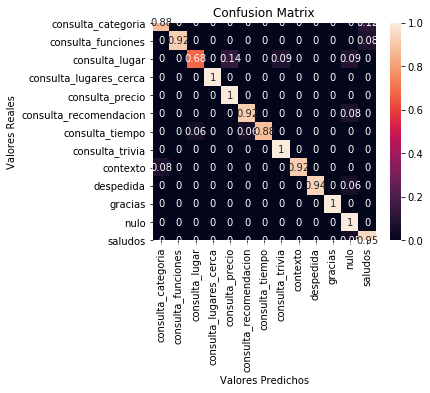

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

cm_df = pd.DataFrame(normal_cm,
                     index = list(tags), 
                     columns = list(tags))

plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Valores Reales')
plt.xlabel('Valores Predichos')
plt.show()